# Data Exploration
On this notebook we will explore the different categories of the dataset

## Considerations
- Only female clothes dataset
- Retrieval images refer to the website/store images, the train & test files are the user images
- Some user images match more than 1 product ie. shoes + dress + bag in the same photo
- Some items in the user images are heavily duplicated #customer_df[customer_df["product"] == 7182] returns 285 images of the same item
- Some labels in the user images dataframe are duplicates but they have more than 1 bboxes because the same piece of clothe appears >1 on the image
- Retrieval images are usually repeated in different angles, distances, etc. but not always. Only ~200k unique items.
- Original product ids start at 1 for every category, there is not a unique identifier
- To find matches a combination of product id + category is used, however there may be many matches, there could be different customer photos of the same product and category and there will likely be more than 1 photo of the same product and category on the store

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('seaborn')

Files are separated into 3 classes: retrieval, train and test. Each of these classes have a json for each of the 11 clothing categories.  

The function below merges all categories json files under the 3 classes, then train and test are also merged so we can do a custom data split.

In [2]:
customer_df = pd.read_csv("./customer_df.csv")
retrieval_df = pd.read_csv("./retrieval_df.csv")

In [15]:
def plot_freqs(df):
    f = plt.figure(figsize=(8,5))
    print(df["category"].value_counts().sort_values(ascending=False))
    df["category"].value_counts().sort_values(ascending=True).plot(
        kind="barh",
        title="Images"
        )
    plt.show()

### Customer data summary

In [4]:
print("Number of photos: ", customer_df.shape[0])
print(customer_df.head(3))
print("Max unique photo times repeated: ", customer_df["photo"].value_counts().sort_values(ascending=False).max())
print("Max unique product times repeated: ", customer_df["product"].value_counts().sort_values(ascending=False).max())
print("Unique photos: ", customer_df["photo"].unique().shape[0])
print("Unique products: ", customer_df["product"].unique().shape[0])

Number of photos:  28175
   photo  product category          id  height   left    top  width
0   4534     7419     bags   7419_bags   358.0  134.0  172.0  120.0
1  16159     9946     bags   9946_bags   303.0  148.0  184.0  120.0
2   6538    10777     bags  10777_bags    88.0  100.0  310.0   57.0
Max unique photo times repeated:  15
Max unique product times repeated:  153
Unique photos:  15492
Unique products:  8582


In [5]:
print(customer_df.drop_duplicates(subset=["product", "category", "photo"]).shape) #11k = duplicate bboxes
print(customer_df.drop_duplicates(subset=["id"]).shape) #(29k - 11k) = duplicate items with diff pics
#these last dups. should be fine as the photos are different, however the retrieval pair photos they match to will bias the outcome of the match.

(19986, 8)
(9203, 8)


dresses      12089
footwear      7195
skirts        2389
tops          2111
leggings      1538
outerwear      984
bags           566
pants          477
hats           353
eyewear        290
belts          183
Name: category, dtype: int64


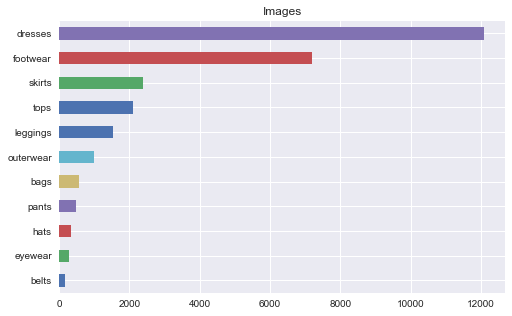

In [16]:
plot_freqs(customer_df)

### Retrieval data summary

In [8]:
print(retrieval_df.shape)
print(retrieval_df.head(3))
print("Max photo times repeated: ", retrieval_df["photo"].value_counts().sort_values(ascending=False).max())
print("Max product times repeated: ", retrieval_df["product"].value_counts().sort_values(ascending=False).max())
print("Unique photos: ", retrieval_df["photo"].unique().shape[0])
print("Unique products: ", retrieval_df["product"].unique().shape[0])

(320050, 4)
    photo  product category      id
0  206867        3     bags  3_bags
1  371076        4     bags  4_bags
2  374473        5     bags  5_bags
Max photo times repeated:  4
Max product times repeated:  455
Unique photos:  319733
Unique products:  63735


In [9]:
print(retrieval_df.drop_duplicates(subset=["id"]).shape)
#about half images have duplicates which are photos from the same item in different angles, zooms, etc.
#not every store item have more than 1 photo

(168786, 4)


In [10]:
#to simplify things, removed all duplicates of photo ids with different category (~500).
retrieval_df = retrieval_df.drop_duplicates(subset=["photo"])
print("Unique photos: ", retrieval_df.shape)

Unique photos:  (319733, 4)


dresses      134053
footwear      62598
tops          53977
outerwear     26505
skirts        14568
bags          12108
pants          5876
leggings       5699
hats           2215
eyewear        1160
belts           974
Name: category, dtype: int64


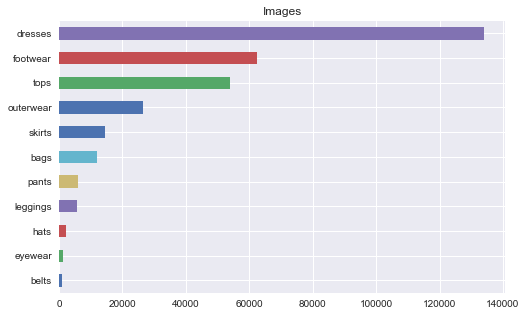

In [25]:
plot_freqs(retrieval_df)

### Example how to find pair matches:
I want to find the shop pair for user image "1.jpg"

In [26]:
#we index by its name on the customer df
customer_df[customer_df["photo"] == 1]
#2 results, we are interested in the dress

,photo,product,category,id,height,left,top,width
1922,1,65901,dresses,65901_dresses,1121.0,560.0,143.0,755.0
21391,1,14177,footwear,14177_footwear,375.0,661.0,1550.0,445.0


In [27]:
#we need to look on the store data for the same id of the dress category
retrieval_df[(retrieval_df["id"] == "65901_dresses")]
#we get more than one photo because is the same product from different angles, zooms, etc

,photo,product,category,id
143922,62650,65901,dresses,65901_dresses
143923,62651,65901,dresses,65901_dresses
143924,62652,65901,dresses,65901_dresses


In [28]:
#needs revisiting to simplify it if finally using this function
def show_image(img_path, bbox=False):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.imshow(mpimg.imread(img_path))
    ax.axis("off")
    
    if bbox == True: #xy = (left, top) 
        img_id = img_path.split("/")[-1].split(".")[0]
        img_data = customer_df[customer_df["photo"] == int(img_id)]
        
        if img_data["category"].unique().shape[0] > 1: #could have either more than 1 category or same category with different bboxes
            print("Categories: ", img_data["category"].value_counts().index.tolist())
            img_category = input("Please specify category: ")
            img_data = img_data[img_data["category"] == img_category]
            
        if img_data.shape[0] > 1: #if image have more than 1 bbox this will plot all of them
            for index, row in img_data.iterrows():
                top = int(row["top"])
                left = int(row["left"])
                width = int(row["width"])
                height = int(row["height"])

                rect = patches.Rectangle(
                    xy=(left,top),
                    width=width,
                    height=height,
                    linewidth=1,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)
            plt.show()
            return 
            
        top = int(img_data["top"].values)
        left = int(img_data["left"].values)
        width = int(img_data["width"].values)
        height = int(img_data["height"].values)
        
        rect = patches.Rectangle(
            xy=(left,top),
            width=width,
            height=height,
            linewidth=1,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)
        plt.show()

Categories:  ['dresses', 'footwear']
Please specify category: dresses


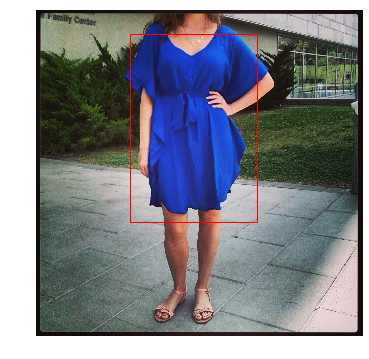

In [29]:
show_image("../photos_resized/1.jpg", bbox=True)

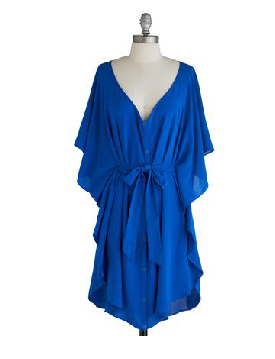

In [30]:
show_image("../photos_resized/62650.jpg")

### How do the missing images affect the dataset?

In [31]:
missing_images = pd.read_csv("./missing_images.csv")
missing_images.drop(columns=["url"],inplace=True)

In [32]:
cust_set = set(customer_df["photo"].tolist()) 
missing_set = set(missing_images["photo"].tolist())
retrieval_set = set(retrieval_df["photo"].tolist()) 

In [33]:
missing_cust = list(cust_set.intersection(missing_set))
print("Customer images missing: ", len(missing_cust))
missing_cust

missing_retrieval = list(retrieval_set.intersection(missing_set))
print("Retrieval images missing: ", len(missing_retrieval))

Customer images missing:  0
Retrieval images missing:  0


### How do the missing images affect the retrieval data?

dresses      134053
footwear      62598
tops          53977
outerwear     26505
skirts        14568
bags          12108
pants          5876
leggings       5699
hats           2215
eyewear        1160
belts           974
Name: category, dtype: int64


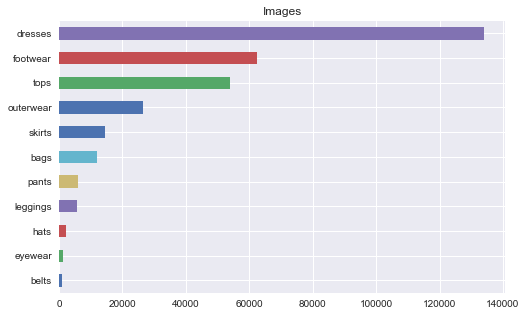

In [34]:
retrieval_available = retrieval_df[~retrieval_df["photo"].isin(missing_retrieval)]
plot_freqs(retrieval_available)

### How do these missing images affect the pair matches?

### Total pair matches

In [35]:
print("Total customer images: ", customer_df.shape[0])
print("Total matches: ", customer_df[customer_df["id"].isin(retrieval_df["id"].tolist())].shape[0])

Total customer images:  28175
Total matches:  28175


dresses      12089
footwear      7195
skirts        2389
tops          2111
leggings      1538
outerwear      984
bags           566
pants          477
hats           353
eyewear        290
belts          183
Name: category, dtype: int64


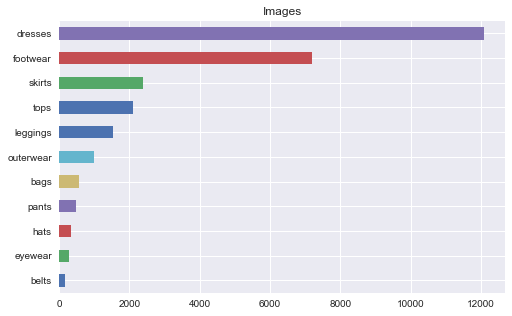

In [36]:
plot_freqs(customer_df[customer_df["id"].isin(retrieval_df["id"].tolist())])

### Available pair matches

In [37]:
print("Total customer images: ", customer_df.shape[0])
customer_available = customer_df[customer_df["id"].isin(retrieval_available["id"].tolist())]
print("Total matches: ", customer_available.shape[0])

Total customer images:  28175
Total matches:  28175


dresses      12089
footwear      7195
skirts        2389
tops          2111
leggings      1538
outerwear      984
bags           566
pants          477
hats           353
eyewear        290
belts          183
Name: category, dtype: int64


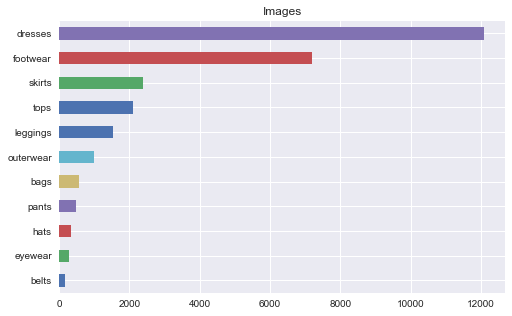

In [38]:
plot_freqs(customer_available)